In [1]:
pip install nb_black

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import my_module as my
import seaborn as sns
from datetime import *
import time
from datetime import timedelta, date

<IPython.core.display.Javascript object>

In [4]:
df = pd.read_csv("df.csv")

<IPython.core.display.Javascript object>

In [5]:
df.shape

(118393, 21)

<IPython.core.display.Javascript object>

In [6]:
my.variable_survey(df)

,variable name,variable type,nbr of distinct values,percentage of NaNs
0,Unnamed: 0,int64,118393,0.0 %
1,customer_id,object,98816,0.0 %
2,customer_unique_id,object,95560,0.0 %
3,order_id,object,98816,0.0 %
4,order_date,object,98257,0.0 %
5,review_score,float64,5,0.0 %
6,payment_sequential,float64,29,0.0 %
7,payment_type,object,4,0.0 %
8,payment_installments,float64,24,0.0 %
9,payment_value,float64,28961,0.0 %


<IPython.core.display.Javascript object>

In [7]:
df["order_date"] = pd.to_datetime(df["order_date"])

<IPython.core.display.Javascript object>

In [8]:
grouped_df = df.groupby("customer_unique_id")
grouped_df = grouped_df.agg({"order_id": "nunique"})
grouped_df = grouped_df.reset_index()
print(grouped_df)

                     customer_unique_id  order_id
0      0000366f3b9a7992bf8c76cfdf3221e2         1
1      0000b849f77a49e4a4ce2b2a4ca5be3f         1
2      0000f46a3911fa3c0805444483337064         1
3      0000f6ccb0745a6a4b88665a16c9f078         1
4      0004aac84e0df4da2b147fca70cf8255         1
...                                 ...       ...
95555  fffcf5a5ff07b0908bd4e2dbc735a684         1
95556  fffea47cd6d3cc0a88bd621562a9d061         1
95557  ffff371b4d645b6ecea244b27531430a         1
95558  ffff5962728ec6157033ef9805bacc48         1
95559  ffffd2657e2aad2907e67c3e9daecbeb         1

[95560 rows x 2 columns]


<IPython.core.display.Javascript object>

In [9]:
grouped_df["order_id"].value_counts()

1     92636
2      2688
3       187
4        30
5         8
6         6
7         3
9         1
17        1
Name: order_id, dtype: int64

<IPython.core.display.Javascript object>

--> Nous constatons donc que uniquement 3% des clients ont passé plus qu'une seule commande. Donc, dans le test de stabilité de classification des clients, nous décidons de tester cette catégorie de clients. Nous allons aussi rajouter un échantillon de 10% des clients qui ont passé une seule commande. 

In [10]:
# recuperer la liste des clients qui ont commandé plusieurs fois
df_test = grouped_df[grouped_df["order_id"] > 1]
list_cliMultiCmnd = df_test["customer_unique_id"].to_list()
len(list_cliMultiCmnd)

2924

<IPython.core.display.Javascript object>

In [11]:
# df contenant uniquement les clients qui ont commandé plusieurs fois
df_simulation = df[df["customer_unique_id"].isin(list_cliMultiCmnd)]
df_simulation.shape

(8539, 21)

<IPython.core.display.Javascript object>

In [12]:
# recuperer la liste des clients qui ont commandé une seule fois
df_test2 = grouped_df[grouped_df["order_id"] == 1]
list_cliUneCmnd = df_test2["customer_unique_id"].to_list()
len(list_cliUneCmnd)

92636

<IPython.core.display.Javascript object>

In [13]:
# df des clientts qui ont commandé une seule fois
all_cli_oneCmd = df[df["customer_unique_id"].isin(list_cliUneCmnd)]
all_cli_oneCmd.shape

(109854, 21)

<IPython.core.display.Javascript object>

In [14]:
# prendre un échantillon de 10% de all_cli_oneCmd
sample_cli_oneCmd = all_cli_oneCmd.sample(frac=0.3, random_state=10)
sample_cli_oneCmd.shape

(32956, 21)

<IPython.core.display.Javascript object>

In [15]:
# concatenate dataframes
df_simulation_hetero = pd.concat([sample_cli_oneCmd, df_simulation], ignore_index=True)

<IPython.core.display.Javascript object>

In [16]:
df_simulation_hetero.shape

(41495, 21)

<IPython.core.display.Javascript object>

### Test de stabilité de clustering

In [15]:
# Option d'affichage
#pd.set_option("display.max_rows", 2000)
#pd.set_option("display.max_columns", 2000)

In [17]:
# determiner le dataframe entre deux dates
def create_df(df, t0, delta_t):
    """
    fonction qui permet de créer un nouveau dataframe à partir du date max de df_init. On rajoute n_jours.
    Les paramètres: 
    - df_init: le dataframe initial, à partir duquel on va extraire max_date
    - df : les données globales à partir desquelles on va extraire les n_jours
    - n_jours: nombre de jours dans timedelta
    La fonction retourne le nouveau dataframe étendu sur timedelta
    """
    nb_days = t0 + delta_t

    min_date = min(df["order_date"])
    max_date = min_date + timedelta(days=nb_days)

    mask = (df["order_date"] >= min_date) & (
        df["order_date"] <= pd.to_datetime(max_date)
    )
    df_periodique = df.loc[mask]

    return df_periodique

<IPython.core.display.Javascript object>

In [18]:
def clean_df(df_toclean):
    """
    fonction qui calcule RFM , sélectionne les features utiles et regroupe les données
    arguments: un dataframe
    """

    min_date = min(df_toclean["order_date"])
    max_date = max(df_toclean["order_date"])

    # calcul RFM
    rfm_results = my.calcul_rfm(df_toclean, min_date, max_date)

    # merge rfm_results avec df_initiale
    df_toclean = df_toclean.merge(rfm_results, how="left", on="customer_unique_id")

    # selectionner les features utiles
    df_toclean = df_toclean[
        [
            "customer_unique_id",
            "frequence",
            "recence",
            "montant",
            "distance_clientVendeur",
            "review_score",
        ]
    ]

    # groupement des données
    df_toclean = df_toclean.groupby(["customer_unique_id"], as_index=False).agg(
        {
            "review_score": "mean",
            "distance_clientVendeur": "mean",
            "frequence": "mean",
            "recence": "min",
            "montant": "mean",
        }
    )
    # df_toclean.drop(columns=['customer_unique_id'], inplace=True)
    return df_toclean

<IPython.core.display.Javascript object>

In [19]:
def kmeans_clustering(df_toSegment, nb_cluster, delta_t, predict=False, model_ref=None):
    """
    Fonction qui permet de standardiser les données et ensuite en appliquer la segmentation kmeans.
    Paramètres: 
    - df: dataframe à segmenter
    -nb_clusters: nombre de clusters à considérer dans la segmentation kmeans
    La fonction retourne le dataframe ainsi que la classification de chaque client
    """
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler

    # standardisation

    df_toSegment_originale = df_toSegment.copy()
    df_toSegment = df_toSegment[
        ["frequence", "recence", "montant", "distance_clientVendeur", "review_score"]
    ]
    scaler = StandardScaler()
    X_norm = scaler.fit_transform(df_toSegment)

    # segmentation

    if delta_t == 0:
        model_ref = KMeans(n_clusters=nb_cluster)
        model_ref.fit(X_norm)
        # df_toSegment = df_toSegment.merge(df_toSegment_originale['customer_unique_id'], left_index=True, right_index=True)

        return model_ref

    else:
        model_periodique = KMeans(n_clusters=nb_cluster)
        model_periodique.fit(X_norm)
        labels_periodique = model_periodique.predict(X_norm)
        labels_ref = model_ref.predict(X_norm)

        return labels_periodique, labels_ref

<IPython.core.display.Javascript object>

In [22]:
# encapsulation de toutes les fonctions
from sklearn.metrics.cluster import adjusted_rand_score


def processus(df, t0, nb_cluster):
    """
    fonction qui calcule ARI
    retourne: courbe d'ARI"
    """
    delta_t = 0
    time_delta = (max(df["order_date"]) - min(df["order_date"])).days
    print("La période complète des commandes porte sur {} jours.".format(time_delta))
    dict_ARI = {}

    if delta_t == 0:
        df_init = create_df(df, t0, delta_t)
        df_init = clean_df(df_init)
        model_ref = kmeans_clustering(df_init, nb_cluster, delta_t, False, None)

    for delta_t in range(15, time_delta - t0, 15):
        df_periodique = create_df(df, t0, delta_t)
        df_periodique = clean_df(df_periodique)
        labels_periodique, labels_ref = kmeans_clustering(
            df_periodique, nb_cluster, delta_t, True, model_ref
        )

        ari = adjusted_rand_score(labels_periodique, labels_ref)
        dict_ARI[delta_t] = ari

    return dict_ARI

<IPython.core.display.Javascript object>

In [23]:
dict_ari = processus(df, 60, 5)

La période complète des commandes porte sur 728 jours.


/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:389: RuntimeWarning: overflow encountered in long_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:389: RuntimeWarning: overflow encountered in long_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))
/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))
/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered

<IPython.core.display.Javascript object>

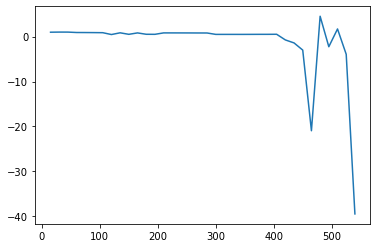

In [29]:
fig = plt.figure()
ax = plt.axes()
plt.plot(dict_ari.keys(), dict_ari.values())
plt.show()

In [24]:
dict_ari

{15: 0.9882933934052074,
 30: 0.955702811530507,
 45: 0.8963084109020982,
 60: 0.8366943213232858,
 75: 0.46318833857361597,
 90: 0.48536870899329415,
 105: 0.7339702112295279,
 120: 0.7949159017102713,
 135: 0.8541853440593207,
 150: 0.9093566926377885,
 165: 0.9178366948641153,
 180: 0.9463589368333301,
 195: 0.9503528785741141,
 210: 0.9559255613773763,
 225: 0.9571073458638399,
 240: 0.9558709523739746,
 255: 0.9586959282777254,
 270: 0.9602368390634504,
 285: 0.9614813923367493,
 300: 0.47176771095149006,
 315: 0.4666510044875282,
 330: 0.31761615743303634,
 345: 0.9679127991093747,
 360: 0.9499839028336512,
 375: 0.9508559330825549,
 390: 0.42107834375229103,
 405: 0.9306602911161999,
 420: 0.4161713597368536,
 435: 0.4125689312601468,
 450: 0.4106581786518285,
 465: 0.40871820316160984,
 480: 0.40933815116152705,
 495: 0.4058329039384702,
 510: 0.411464598880043,
 525: -0.4935159886392602,
 540: -0.8203011523310486,
 555: -1.8301309265539987,
 570: -7.184630589994936,
 585: 5.84

<IPython.core.display.Javascript object>